## Install for reading TFRecords

In [ ]:
!pip3 install tfrecord

  Created wheel for tfrecord: filename=tfrecord-1.11-cp36-none-any.whl size=10785 sha256=3e008d27fae5007d25f7d08ceeceeb3063c6c564f98e8175cd52ca5ae3af5b71
  Stored in directory: /root/.cache/pip/wheels/3b/e6/16/a2acd21b31e0be06090bf14b5d7494e124964610bd16dd588f
Successfully built tfrecord


## Reading and parsing data

In [ ]:
from tfrecord.torch.dataset import TFRecordDataset

In [1]:
!gcloud auth activate-service-account --key-file YOUR_CLOUD_STORAGE_KEY.json
!gsutil cp gs://YOUR_CLOUD_BUCKET_NAME/SAR2RGB_dataset1.tfrecord.gz .

In [ ]:
!gunzip SAR2RGB_dataset1.tfrecord.gz

In [ ]:
def transform_to_touple(feature):
    image=[] 
    B4 = feature['B4'].reshape((256,256))
    B3 = feature['B3'].reshape((256,256))
    B2 = feature['B2'].reshape((256,256))

    VV = feature['VV'].reshape((256,256))
    VH = feature['VH'].reshape((256,256))
    rgb = torch.tensor([B4,B3,B2]) 
    sar = torch.tensor([VV,VH])
    # image = image.transpose(1,0).transpose(2,1)
    return (sar, rgb)

In [ ]:
tfrecord_path = "SAR2RGB_dataset1.tfrecord"
index_path = None
description = {"VV": "float", "## Visualize a image from dataset## Visualize a image from datasetVH": "float", "B4": "float", "B3":"float", "B2": "float"}
dataset = TFRecordDataset(tfrecord_path, index_path, description, transform=transform_to_touple)

## Visualize a image from dataset

In [ ]:
import torch
import numpy as np

In [ ]:
image=[]
colored=[]
for idx,i in enumerate(dataset):
    if idx == 637:
        image = i[0]
        colored = i[1]
        print(image.shape)
        break

torch.Size([2, 256, 256])


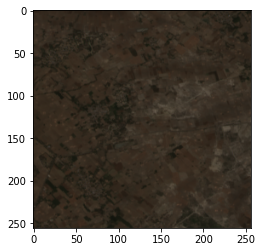

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(colored.transpose(1,0).transpose(2,1))

## DataLoader

In [ ]:
from torch.utils.data.## DataLoaderdataset import Dataset
from torch.utils.data.dataloader import DataLoader

In [ ]:
for i in dataset:
    print(i[0].shape)
    break

torch.Size([2, 256, 256])


In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=32)

## Model Architecture Pix2Pix

In [ ]:
class Encoder_Block(torch.nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=4, stride=2, padding=1, apply_act=True, apply_batch_norm=True):
        super(Encoder_Block ,self).__init__()
        self.conv_step = torch.nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding)
        self.activation_step = torch.nn.LeakyReLU(0.2)

        # argument is equal to C in NCHW, i.e channels after conv2d
        self.batch_norm = torch.nn.BatchNorm2d(out_filters)

        # applying batch norm and activation optionally
        self.apply_activation = apply_act
        self.apply_batch_norm = apply_batch_norm

        # initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, torch.nn.Conv2d):
                # mean = 0.0, std=0.2
                torch.nn.init.normal(layer.weight, 0.0, 0.2)
  
    def forward(self, input):
        x = self.conv_step(input)
        if self.apply_batch_norm == True:
            x = self.batch_norm(x)

        if self.apply_activation == True:
            x = self.activation_step(x)

        return x

class Decoder_Block(torch.nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=4, stride=2, padding=1, apply_dropout=True, apply_batch_norm=True):
        super(Decoder_Block ,self).__init__()
        self.conv_trans = torch.nn.ConvTranspose2d(in_filters, out_filters, kernel_size, stride, padding)
        self.batch_norm = torch.nn.BatchNorm2d(out_filters)
        self.dropout = torch.nn.Dropout(0.5)
        self.apply_batch_norm = apply_batch_norm
        self.activation_step = torch.nn.ReLU()
        self.apply_dropout = apply_dropout

        # initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, torch.nn.Conv2d):
            # mean = 0.0, std=0.2
            torch.nn.init.normal(layer.weight, 0.0, 0.2)

    def forward(self, input):
        # convetionally batch_norm is used after activation. But in case of relu its vice versa.
        x = self.conv_trans(input)
        if self.apply_batch_norm == True:
            x = self.batch_norm(x)
    
        x = self.activation_step(x)
    
        if self.apply_dropout == True:
            x = self.dropout(x)

    return x

# Encoder
# C64-C128-C256-C512-C512-C512-C512-C512

# Decoder
# CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
class Generator_Unet(torch.nn.Module):
    def __init__(self, input_channels=3, out_channels=3):
        super(Generator_Unet ,self).__init__()
        # Define layers
        self.conv1 = Encoder_Block(input_channels, 64, apply_act=False, apply_batch_norm=False) # 512
        self.conv2 = Encoder_Block(64, 128) # 256
        self.conv3 = Encoder_Block(128, 256) # 128
        self.conv4 = Encoder_Block(256, 512) # 64
        self.conv5 = Encoder_Block(512, 512) # 32
        self.conv6 = Encoder_Block(512, 512) # 16
        self.conv7 = Encoder_Block(512, 512) # 8
        self.conv8 = Encoder_Block(512, 512, apply_batch_norm=False) #4 -> 2

        self.deconv1 = Decoder_Block(512, 512, apply_dropout=True) # +512 concat
        self.deconv2 = Decoder_Block(1024, 512, apply_dropout=True)
        self.deconv3 = Decoder_Block(1024, 512, apply_dropout=True)
        self.deconv4 = Decoder_Block(1024, 512)
        self.deconv5 = Decoder_Block(1024, 256)
        self.deconv6 = Decoder_Block(512, 128)
        self.deconv7 = Decoder_Block(256, 64)
        self.deconv8 = Decoder_Block(128, out_channels)

        self.activation = torch.nn.Tanh()

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)

        decoded_x1 = self.deconv1(x8)
        # pytorch accepts tensor as NCHW(0123), concatenate channel wise, dim=1

        decoded_x1 = torch.cat([decoded_x1, x7], dim=1)

        decoded_x2 = self.deconv2(decoded_x1)
        decoded_x2 = torch.cat([decoded_x2, x6], dim=1)

        decoded_x3 = self.deconv3(decoded_x2)
        decoded_x3 = torch.cat([decoded_x3, x5], dim=1)

        decoded_x4 = self.deconv4(decoded_x3)
        decoded_x4 = torch.cat([decoded_x4, x4], dim=1)

        decoded_x5 = self.deconv5(decoded_x4)
        decoded_x5 = torch.cat([decoded_x5, x3], dim=1)

        decoded_x6 = self.deconv6(decoded_x5)
        decoded_x6 = torch.cat([decoded_x6, x2], dim=1)

        decoded_x7 = self.deconv7(decoded_x6)
        decoded_x7 = torch.cat([decoded_x7, x1], dim=1)

        decoded_x8 = self.deconv8(decoded_x7)

        x = self.activation(decoded_x8)
        return x


In [ ]:
class Discriminiator(torch.nn.Module):
    def __init__(self, in_channels, out_filters=1):
        super(Discriminiator, self).__init__()
        self.conv1 = Encoder_Block(in_channels, 64, apply_act=False, apply_batch_norm=False)
        self.conv2 = Encoder_Block(64, 128)
        self.conv3 = Encoder_Block(128, 256)
        self.conv4 = Encoder_Block(256, 512)
        self.conv5 = Encoder_Block(512, out_filters)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x, orignal):
        x = torch.cat([x,orignal], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.activation(x)

        return x
# Discriminiator(6,1)(torch.randn((1,3,256,256)),torch.randn((1,3,256,256))).shape

## Hyperparameters Loss Optimizer

In [ ]:
epochs= 10
lr = 0.0002

loss_Gen = torch.nn.L1Loss()## Hyperparameters Loss Optimizer
loss_Dis = torch.nn.BCELoss()

In [ ]:
Gen = Generator_Unet(input_channels=2, out_channels=3).to('cuda')

# input will be concatenated for discriminator, real.cat(fake) channel wise, so 6 channels not 3
Dis = Discriminiator(in_channels=5, out_filters=1).to('cuda')

# Pass weights, Bias and grads using parameters function to optimizer
G_optimizer = torch.optim.Adam(Gen.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(Dis.parameters(), lr=lr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


## Training Loop

In [2]:
# squeeze and unsqueeze will create a poor readablility, i will fix this later
for  i in range(5):
    step = 0
    running_Dis_loss=0
    running_Gen_loss=0
    for j, (sar, rgb) in enumerate(loader):
        # print("hi")
        sar_image = sar.to('cuda')
        rgb_image = rgb.to('cuda')

        # Real image to Dis
        pred_for_real = Dis(sar_image, rgb_image)
        # pred_for_real = pred_for_real.squeeze()

        labels = torch.ones(pred_for_real.shape).to('cuda')
        # print("1")
        loss_for_real = loss_Dis(pred_for_real, labels)

        # Fake image to Dis
        fake_rgb_img = Gen(sar_image)
        pred_for_fake = Dis(sar_image, fake_rgb_img)

        labels_zeros = torch.zeros(pred_for_fake.shape).to('cuda')
        loss_for_fake = loss_Dis(pred_for_fake, labels_zeros)
        # print("2")
        total_loss_dis = loss_for_real + loss_for_fake

        Dis.zero_grad()
        total_loss_dis.backward()
        D_optimizer.step()

        # Generator loss calculations
        r = Gen(sar_image)
        pred = Dis(sar_image, r).squeeze()

        loss_BCE_gen = loss_Dis(pred, torch.ones(pred.shape).to('cuda'))
        loss_L1_gen = loss_Gen(r, rgb_image) * 100 # lambda=100

        loss_total_gen = loss_BCE_gen + loss_L1_gen

        Gen.zero_grad()
        loss_total_gen.backward()

        G_optimizer.step()

        # Running loss
        running_Dis_loss= running_Dis_loss + total_loss_dis
        running_Gen_loss = running_Gen_loss + loss_total_gen

        # break
        step = step+1
        # print(step)
        if step % 10 == 0 and step !=0:
            print("=> step : ", step, ", dis loss: ",running_Dis_loss.item()/j, " gen loss: ",running_Gen_loss.item()/j)
    print("epoch ", i ," done!")

In [ ]:
one = torch.randn((1,2,256,256))
two = torch.randn((1,3,256,256))

In [ ]:
torch.cat([one,two],1)

tensor([[[[-1.4771, -0.2719,  0.2678,  ..., -1.0344,  0.3731, -0.0185],
          [ 0.4458,  1.4850,  0.1598,  ..., -0.2800,  1.5122,  0.6569],
          [-0.5593, -1.3141, -0.9140,  ...,  0.7739,  1.5288, -0.5665],
          ...,
          [ 0.9224, -1.1139, -0.7221,  ..., -1.4723, -0.1604, -0.4863],
          [-0.2204,  1.9042,  1.5258,  ..., -1.1601,  2.3661,  0.5297],
          [-0.2501,  0.2060, -4.2613,  ..., -0.0863, -0.7221,  1.2502]],

         [[-0.9908,  0.2622, -1.4198,  ..., -1.6194,  1.1905,  0.1925],
          [-0.3866, -0.9883, -0.1852,  ..., -1.6858, -0.2623, -0.9316],
          [-1.3627, -0.5151,  0.6992,  ...,  0.4277, -0.2362, -1.5825],
          ...,
          [-1.9024, -0.9784,  0.7413,  ..., -0.4372,  0.6750, -0.7183],
          [ 0.4395, -0.2447,  1.8019,  ..., -0.3763, -1.9916, -1.7588],
          [ 1.9950, -1.7972,  0.3886,  ...,  0.8767, -0.4105, -0.0120]],

         [[ 0.5480,  0.4177,  0.0839,  ...,  2.1807, -1.3821, -1.4171],
          [-1.3766, -1.4454,  

## Testing on single image

In [ ]:
pred = Gen(image.to('cuda').unsqueeze(0))
pred.shape
# plt.imshow(torch.tensor(pred.squeeze().transpose(0,1).transpose(1,2).to('cpu'), requires_grad=False))
# pred.squeeze().transpose(0,1).transpose(1,2).to('cpu').shape

torch.Size([1, 3, 256, 256])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


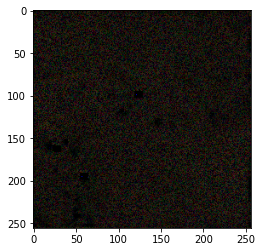

In [ ]:
plt.imshow(torch.tensor(pred.squeeze().transpose(0,1).transpose(1,2).to('cpu'), requires_grad=False))